In [1]:
import numpy as np
import pyhdf
from pyhdf.SD import SD, SDC
from pyhdf.HDF import *
from pyhdf.VS import *
from datetime import datetime, timezone
from scipy import interpolate
import glob
import os
import matplotlib.pyplot as plt
import netCDF4 as nc
from geopy.distance import geodesic

In [2]:
## ===============================================
def read_2b_cldclass_lidar(cs_file,latbin=None):
## ===============================================
  f_2b_cldclass_lidar=SD(cs_file, SDC.READ)
  sds_obj=f_2b_cldclass_lidar.select('CloudLayerBase')
  cs_clb =sds_obj.get()
  sds_obj=f_2b_cldclass_lidar.select('CloudLayerTop')
  cs_clt =sds_obj.get()

  ## geolocation fields
  sdc_2bcldclass_lidar=HDF(cs_file, SDC.READ)
  vs_2bcldclass_lidar=sdc_2bcldclass_lidar.vstart()
  cs_QC = np.squeeze(vs_2bcldclass_lidar.attach('Data_quality')[:])
  Latitude = np.squeeze(vs_2bcldclass_lidar.attach('Latitude')[:])
  Longitude = np.squeeze(vs_2bcldclass_lidar.attach('Longitude')[:])

  ilat = np.squeeze(np.argwhere((Latitude >= latbin[0]) & (Latitude <= latbin[1])))
  cs_clb = cs_clb[ilat,:]
  cs_clt = cs_clt[ilat,:]
  cs_QC = cs_QC[ilat]
  Latitude = Latitude[ilat]
  Longitude = Longitude[ilat]

  return(cs_clb,cs_clt,cs_QC,Latitude,Longitude)

## ===============================================
def read_cs_ecmwf(aux_file,latbin=None):
## ===============================================
  f_ecmwf=SD(aux_file, SDC.READ)
  sds_obj=f_ecmwf.select('Pressure')
  Pressure =sds_obj.get()
  sds_obj=f_ecmwf.select('Temperature')
  Temperature =sds_obj.get()
  sds_obj=f_ecmwf.select('Specific_humidity')
  Specific_humidity =sds_obj.get()
  #sds_obj=f_ecmwf.select('U_velocity')
  #U_velocity =sds_obj.get()
  #sds_obj=f_ecmwf.select('V_velocity')
  #V_velocity =sds_obj.get()

  ## geolocation fields
  sdc_ecmwf=HDF(aux_file, SDC.READ)
  vs_ecmwf=sdc_ecmwf.vstart()
  EC_height = np.squeeze(vs_ecmwf.attach('EC_height')[:])
  Profile_time = np.squeeze(vs_ecmwf.attach('Profile_time')[:])
  UTC_start = np.squeeze(vs_ecmwf.attach('UTC_start')[:])
  #TAI_start = np.squeeze(vs_ecmwf.attach('TAI_start')[:])
  Latitude = np.squeeze(vs_ecmwf.attach('Latitude')[:])
  Longitude = np.squeeze(vs_ecmwf.attach('Longitude')[:])
  DEM_elevation = np.squeeze(vs_ecmwf.attach('DEM_elevation')[:])
  Skin_temperature = np.squeeze(vs_ecmwf.attach('Skin_temperature')[:])
  Surface_pressure = np.squeeze(vs_ecmwf.attach('Surface_pressure')[:])
  Temperature_2m = np.squeeze(vs_ecmwf.attach('Temperature_2m')[:])
  #Sea_surface_temperature = np.squeeze(vs_ecmwf.attach('Sea_surface_temperature')[:])
  U10_velocity = np.squeeze(vs_ecmwf.attach('U10_velocity')[:])
  V10_velocity = np.squeeze(vs_ecmwf.attach('V10_velocity')[:])


  UTC_Time = UTC_start + Profile_time
  UTC_Time = UTC_Time/60./60.
  ilat = np.squeeze(np.argwhere((Latitude >= latbin[0]) & (Latitude <= latbin[1])))
  Pressure = Pressure[ilat,:]
  Temperature = Temperature[ilat,:]
  Specific_humidity = Specific_humidity[ilat,:]
  DEM_elevation = DEM_elevation[ilat]
  Skin_temperature = Skin_temperature[ilat]
  Temperature_2m = Temperature_2m[ilat]
  U10_velocity = U10_velocity[ilat]
  V10_velocity = V10_velocity[ilat]
  UTC_Time = UTC_Time[ilat]


  return(Pressure,DEM_elevation,Temperature,Specific_humidity,EC_height,Temperature_2m,U10_velocity,V10_velocity,UTC_Time)

In [3]:
def find_files(directory, prefix):
    matching_files = []
    for filename in os.listdir(directory):
        if filename.startswith(prefix):
            matching_files.append(os.path.join(directory, filename))
    return matching_files

def gather_files(YYYY, DDD, HH, ROOT):
    ABI_ = {
        "ROOT_PATH": None,

        "YYYY": None,
        "DDD": None,
        "HH": None,

        "00": [],
        "10": [],
        "15": [],
        "20": [],
        "30": [],
        "40": [],
        "45": [],
        "50": [],

        "L200": None,
        "L210": None,
        "L220": None,
        "L230": None,
        "L240": None,
        "L250": None,

        "everyten": False,
    }

    _ABI_PATH_ = ROOT + YYYY + "/" + DDD + "/" + HH
    
    for filename in os.listdir(_ABI_PATH_):
        if ABI_["ROOT_PATH"] == None:
            ABI_["ROOT_PATH"] = _ABI_PATH_
            ABI_["YYYY"] = filename[27:31]
            ABI_["DDD"] = filename[31:34]
            ABI_["HH"] = filename[34:36]
        MM = filename[36:38]
        if MM == "10":
            ABI_["everyten"] = True
        ABI_[f"{MM}"].append(filename)
    
    return ABI_

def get_L1B_L2(abipaths, l2path, YYYY, DDD, HH, ROOT):

    # ASSERT ALL ABI CHANNELS PRESENT !!!!!!!!!!!!!!!!!!!!
    if len(abipaths) != 16:
        raise ImportError("This hour is bad")
    # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


    # LOAD EACH ABI CHANNEL IMAGE
    CHANNELS = []
    # ROOT = "/css/geostationary/BackStage/GOES-16-ABI-L1B-FULLD/"

    print("Loading Data")
    
    for file in abipaths:
        L1B = np.array(nc.Dataset(ROOT + "/" + YYYY + "/" + DDD + "/" + HH + "/" + file, 'r')["Rad"])
        CHANNEL = int(file[19:21])
        CHANNELS.append((L1B, CHANNEL))

    print("Finished Loading")

    # SORT CHANNELS
    CHANNELS.sort(key=lambda x: x[1])
    CHANNELS = [C[0] for C in CHANNELS]

    T = []
    #RESIZE ALL CHANNELS TO SAME SIZE
    for C in CHANNELS:
        S = C.shape[0] // 5424
        if S == 1:
            C = np.repeat(C, 2, axis=0)
            C = np.repeat(C, 2, axis=1)
        if S == 4:
            C = C[::2, ::2]
        T.append(C)

    CHANNELS = T

    # STACK ABI CHANNELS INTO SINGLE IMAGE
    ABI = np.stack(CHANNELS, axis=2)

    return ABI

In [4]:
BOUND_SIZE = 2000
LENGTH = 10848

In [5]:
# READ IN ABI_EAST in order to find the latitude and longitude of each file
f = nc.Dataset("/home/szhang16/ABI_EAST_GEO_TOPO_LOMSK.nc")
abiLong = np.array(f['Longitude'])
abiLat = np.array(f['Latitude'])

# Get the latitude and longitude boundaries within the bounded region

abiLongB = abiLong[BOUND_SIZE:LENGTH-BOUND_SIZE, BOUND_SIZE:LENGTH-BOUND_SIZE]
abiLatB = abiLat[BOUND_SIZE:LENGTH-BOUND_SIZE, BOUND_SIZE:LENGTH-BOUND_SIZE]
abiLongB[abiLongB == -999] = 10
abiLatB[abiLatB == -999] = 10
longMin = abiLongB.min()
longMax = abiLongB.max()
latMin = abiLatB.min()
latMax = abiLatB.max()

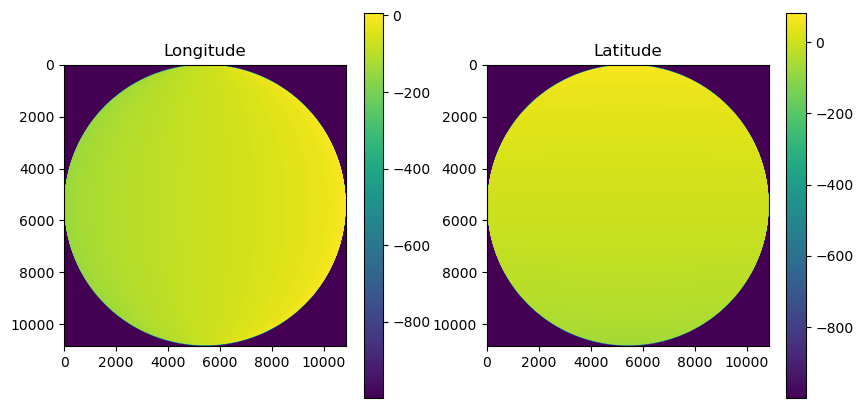

In [6]:
# Double check if they loaded correctly
# abiLongG = abiLong.copy()
# abiLatG = abiLat.copy()

# abiLongG = abiLongG.flatten()
# abiLatG = abiLatG.flatten()

# mask = (abiLongG != -999) & (abiLatG != -999)
# abiLongG = abiLongG[mask]
# abiLatG = abiLatG[mask]

# print(abiLongG.shape)

# abiLongG = abiLongG[::1000]
# abiLatG = abiLatG[::1000]

# plt.scatter(abiLongG, abiLatG, c='blue', marker='o')
# plt.grid(True)
# plt.show()

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
im0 = axes[0].imshow(abiLong)
im1 = axes[1].imshow(abiLat)
# axes[0].axis('off')
# axes[1].axis('off')
axes[0].set_title("Longitude")
axes[1].set_title("Latitude")
plt.colorbar(im0, ax=axes[0])
plt.colorbar(im1, ax=axes[1])

# TEST FOOTPRINT SIZE
# for i in np.arange(5000,5100):
#   coords_1 = (abiLat[i,5000],abiLong[i,5000])
#   coords_2 = (abiLat[i+1,5000],abiLong[i+1,5000])
 
#   dis = geodesic(coords_1,coords_2).km
#   print(dis)

In [7]:
# Store already parsed files for more efficiency

GATHERED_ABI_FILES = {}
COLLECTED_ABI_DATA = {}

In [8]:
latSlice = abiLat[:, 5424]
latSlice = latSlice[18:-18]
longSlice = abiLong[5424, :]
longSlice = longSlice[18:-18]
latSlice = latSlice[::-1]

In [11]:
def interpArray(a):
    N = len(a)
    M = len(a[0])
    a_interp = np.zeros((N, 40))

    for i in range(N):
        f = interpolate.interp1d(np.linspace(0,1,M), a[i], kind='linear')
        a_interp[i] = f(np.linspace(0, 1, 40))

    return a_interp

def processTime(t, yy, ddn, lat, lon, ABI_ROOT):
    if np.floor(t) < 19:
        raise ValueError("Times must be between 19-23")

    if lat < latMin or lat > latMax or lon < longMin or lon > longMax:
        raise ValueError("Latitude and Longitude are not correctly bounded")
    # # Find the proper index using Manhattan distance
    # distances = np.abs(abiLat - lat) + np.abs(abiLong - lon)

    # # distances = distances[BOUND_SIZE:LENGTH-BOUND_SIZE,BOUND_SIZE:LENGTH-BOUND_SIZE]
    
    # # Find minimum value in distances array
    # coords = np.unravel_index(distances.argmin(), distances.shape)
    # # coords = np.array(coords) + BOUND_SIZE
    # # if coords[0] < BOUND_SIZE or coords[1] < BOUND_SIZE or coords[1] > LENGTH-BOUND_SIZE or coords[0] > LENGTH-BOUND_SIZE:
    # #     raise ImportError("Bad latitude and longitude")

        
    # MORE OPTIMIZED: Find the proper index using Binary Search on the middle slices, then find the smallest lat/lon in a 2000x2000 area around that point.
    # In case the coords are on the very boundaries of the 2000x2000 area, fallback to the old method

    AREA_SIZE = 1000

    lati = len(latSlice) - np.searchsorted(latSlice, lat) + 17
    loni = np.searchsorted(longSlice, lon) + 18
    
    distances = np.abs(abiLat[lati-AREA_SIZE:lati+AREA_SIZE, loni-AREA_SIZE:loni+AREA_SIZE] - lat) + np.abs(abiLong[lati-AREA_SIZE:lati+AREA_SIZE, loni-AREA_SIZE:loni+AREA_SIZE] - lon)
    coords = np.array(np.unravel_index(distances.argmin(), distances.shape))
    if coords[0] == 0 or coords[1] == 0 or coords[1] == 2*AREA_SIZE-1 or coords[0] == 2*AREA_SIZE - 1:
        print("FALLBACK")
        distances = np.abs(abiLat - lat) + np.abs(abiLong - lon)
        coords = np.unravel_index(distances.argmin(), distances.shape)
    else:
        coords[0] += lati - AREA_SIZE
        coords[1] += loni - AREA_SIZE

    if coords[0] < BOUND_SIZE or coords[1] < BOUND_SIZE or coords[1] > LENGTH-BOUND_SIZE or coords[0] > LENGTH-BOUND_SIZE:
        raise ValueError("Bad latitude and longitude")
        
    # print(coords[0] - ncoords[0], coords[1] - ncoords[1])

    hour = np.floor(t).astype(int)

    # Gather the ABI_FILE
    DATA = GATHERED_ABI_FILES.get(f'{yy}-{ddn}-{hour}')
    if DATA is None:
        DATA = gather_files(str(yy), str(ddn), str(hour), ABI_ROOT)
        GATHERED_ABI_FILES[f'{yy}-{ddn}-{hour}'] = DATA

    # Find the closest minute
    if DATA["everyten"]:
        minutes = np.round((t - np.floor(t)) * 6).astype(int) * 10
    else:
        minutes = np.round((t - np.floor(t)) * 4).astype(int) * 15

    # If minutes is closer to the next hour, shift the hour forward by one, unless that would cause a day shift
    if minutes == 60:
        if hour != 23:
            hour += 1
            minutes = 0
        else:
            if DATA["everyten"]:
                minutes = 50
            else:
                minutes = 45

    minutes = str(minutes)
    if minutes == "0":
        minutes ="00"

    ABI = COLLECTED_ABI_DATA.get(f'{yy}-{ddn}-{hour}-{minutes}')
    if ABI is None:
        ABI = get_L1B_L2(DATA[minutes], DATA["L200"], DATA["YYYY"], DATA["DDD"], DATA["HH"], ABI_ROOT)
        COLLECTED_ABI_DATA[f'{yy}-{ddn}-{hour}-{minutes}'] = ABI

    chip = ABI[coords[0]-64:coords[0]+64, coords[1]-64:coords[1]+64, :]

    return chip, coords

translation = [1, 2, 0, 4, 5, 6, 3, 8, 9, 10, 11, 13, 14, 15]
    
def processFile(yy, ddn, orbit, latb):
    cloudsatpath = '/explore/nobackup/people/jgong/cloudsat/'
    #cloudsatpath = '/discover/nobackup/jgong/cloudsat/'
    cs_file = glob.glob(cloudsatpath+'2B-CLDCLASS-LIDAR/'+yy+'/'+ddn+'/'+yy+ddn+'*'+orbit+'*2B-CLDCLASS-LIDAR*'+'P1_R05*.hdf')
    aux_file = glob.glob(cloudsatpath+'ECMWF-AUX/'+yy+'/'+ddn+'/'+yy+ddn+'*'+orbit+'*ECMWF-AUX*'+'P1_R05*.hdf')

    if len(cs_file) == 0 or len(aux_file) == 0:
        print("NO CS OR AUX")
        return

    [Pressure,DEM_elevation,Temperature,Specific_humidity,EC_height,Temperature_2m,\
        U10_velocity,V10_velocity,UTC_Time] = read_cs_ecmwf(aux_file[0],latbin=latb)

    ##========== read 2b-cldclass-lidar ================================
    [cs_clb,cs_clt,cs_QC,Latitude,Longitude] = read_2b_cldclass_lidar(cs_file[0],latbin=latb)
    
    Pressure = interpArray(Pressure)
    Temperature = interpArray(Temperature)
    Specific_humidity = interpArray(Specific_humidity)
    
    N = len(cs_clb)

    cs_clb_2 = np.floor(2 * cs_clb).astype(int)
    cs_clt_2 = np.floor(2 * cs_clt).astype(int)
    
    newRescaled = np.zeros((N, 40)).astype(int)
    for i in range(N):
        for j in range(10):
            if cs_clb[i, j] == -99:
                break
            newRescaled[i, cs_clb_2[i, j]:cs_clt_2[i, j]+1] = 1

    # Find corresponding ABI file to the UTC_Time

    i = 0
    
    while i < N:
        try:
            chip, coords = processTime(UTC_Time[i], yy, ddn, Latitude[i], Longitude[i], '/explore/nobackup/people/szhang16/ABI-L1b-RadF/')
        except ValueError:
            i += 20
            continue
        except ImportError:
            print("MISSING ABI DATA")
            print(yy, ddn, UTC_Time[i])
            i += 90
            continue
            
        # dRange = np.arange(i-45, i+46)
        # Reverse the CloudSAT Data
        dRange = np.arange(i+46, i-45, -1)
        aux_data = {
            "Pressure": Pressure[dRange],
            "DEM_elevation": DEM_elevation[dRange],
            "Temperature": Temperature[dRange],
            "Specific_humidity": Specific_humidity[dRange],
            "Temperature_2m": Temperature_2m[dRange],
            "U10_velocity": U10_velocity[dRange],
            "V10_velocity": V10_velocity[dRange],
            "UTC_Time": UTC_Time[dRange],
            "Latitude": Latitude[dRange],
            "Longitude": Longitude[dRange],
            "Cloud_mask": newRescaled[dRange],
        }

        fileName = f'{yy}-{ddn}-{orbit}_{coords[0]}-{coords[1]}'

        chip = chip[..., translation]

        np.savez('/explore/nobackup/people/szhang16/abiCloudSATChips/' + fileName, chip=chip, data=aux_data)
        print(fileName, UTC_Time[i])

        print("Done Saving")

        i += 45

        # fig,(ax1,ax2,ax3) = plt.subplots(1,3, figsize=(15, 5))
        # ax1.imshow(newRescaled[dRange],aspect="auto")
        # ax1.set_title('Cloud Mask Curtain')
        # ax3.contourf(chip[:,:,12],cmap="RdBu_r")
        # ax3.set_title('ABI@12um')
        # im2 = ax2.imshow(Temperature[dRange, 0:31], aspect="auto")
        # ax2.set_title('Temperature')
        # plt.colorbar(im2, ax=ax2)

        # plt.show()

        # print("LATITUDE, LONGITUDE")

        # print("CENTER: ", abiLat[coords[0], coords[1]], abiLong[coords[0], coords[1]])
        # print("+64 +64: ", abiLat[coords[0] + 64, coords[1] + 64], abiLong[coords[0] + 64, coords[1] + 64])
        # print("+64 -64: ", abiLat[coords[0] + 64, coords[1] - 64], abiLong[coords[0] + 64, coords[1] - 64])
        # print("-64 -64: ", abiLat[coords[0] - 64, coords[1] + 64], abiLong[coords[0] - 64, coords[1] + 64])
        # print("-64 -64: ", abiLat[coords[0] - 64, coords[1] - 64], abiLong[coords[0] - 64, coords[1] - 64])

In [12]:
#=================================
#    MAIN
#=================================
# yy = '2019'
# ddn = '045'; orbit = '68181'

# processFile(yy, ddn, orbit, (latMin, latMax))

# for filename in os.listdir('/explore/nobackup/people/jgong/cloudsat/2B-CLDCLASS-LIDAR/2019/285'):
#     if filename.endswith('.hdf'):
#         if int(filename[7:9]) > 18:
#             print(filename)
#             processFile("2019", "285", filename[14:19], (latMin, latMax))

ROOT_DIR = '/explore/nobackup/people/jgong/cloudsat/2B-CLDCLASS-LIDAR'

for year in os.listdir(ROOT_DIR):
    if year == "2018":
        continue
    for day in os.listdir(ROOT_DIR + '/' + year):
        GATHERED_ABI_FILES = {}
        COLLECTED_ABI_DATA = {}
        for file in os.listdir(ROOT_DIR + '/' + year + '/' + day):
            if file.endswith('hdf'):
                orbit = file[14:19]
                if int(file[7:9]) > 18:
                    print(f"PROCESSING FILE {year} {day} {orbit}")
                    processFile(year, day, orbit, (latMin, latMax))

# for i in np.arange(10):
#   tmp=np.squeeze(cs_clt[:,i])
#   ind=np.argwhere(tmp>0)
#   print(len(ind),len(tmp))

#---- implementing the 40-level cloud mask processing code from ----
#---- https://colab.research.google.com/drive/1cIsSLS5ht8PXQ8bAbJpboAIxrnanwupu -----

PROCESSING FILE 2019 360 72784
Loading Data
Finished Loading
2019-360-72784_8835-4113 20.29173889160156
Done Saving
2019-360-72784_8799-4095 20.293738878038194
Done Saving
2019-360-72784_8762-4077 20.295738864474824
Done Saving
2019-360-72784_8726-4060 20.297738850911458
Done Saving
2019-360-72784_8689-4042 20.29973890516493
Done Saving
2019-360-72784_8652-4024 20.301738891601563
Done Saving
2019-360-72784_8614-4006 20.303738878038192
Done Saving
2019-360-72784_8577-3989 20.30573886447483
Done Saving
2019-360-72784_8539-3971 20.30773885091146
Done Saving
2019-360-72784_8501-3954 20.30973890516493
Done Saving
2019-360-72784_8462-3936 20.311738891601564
Done Saving
2019-360-72784_8424-3919 20.313738878038194
Done Saving
2019-360-72784_8385-3902 20.315738864474827
Done Saving
2019-360-72784_8346-3884 20.317738850911457
Done Saving
2019-360-72784_8306-3867 20.31973890516493
Done Saving
2019-360-72784_8267-3850 20.321738891601562
Done Saving
2019-360-72784_8227-3833 20.323738878038192
Done 

KeyboardInterrupt: 

2018-285-66353_8324-5156.npz


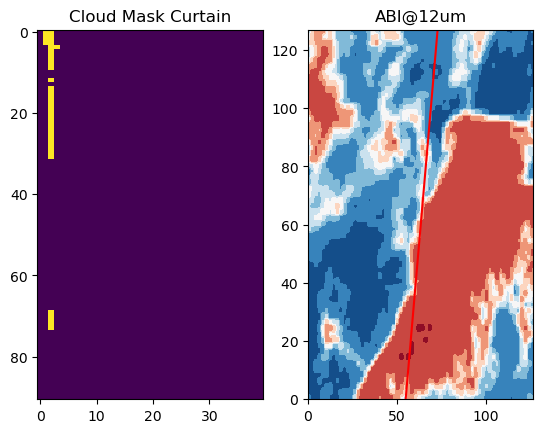

In [57]:
%run ../read_abiCloudSatTruth.py